In [129]:
from pathlib import Path
import re, numpy as np, pandas as pd, mne
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.metrics import accuracy_score, cohen_kappa_score, f1_score, confusion_matrix, classification_report
from sklearn.model_selection import GroupKFold
from sklearn.model_selection import LeaveOneGroupOut

import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning)
mne.set_log_level("ERROR")

In [112]:
from src.feature_extraction import epochs_to_bandpower

In [113]:
import sys, importlib.util, os
parentPath = Path.cwd().parent
sys.path.insert(0, str(parentPath))  

In [114]:
DATA = Path(f"{parentPath}/data")
DER  = DATA / "derivatives"  
FIGS = Path(f"{parentPath}/figs"); FIGS.mkdir(parents=True, exist_ok=True)

In [115]:
paths = sorted(DER.glob("*-aligned128-epo.fif")) or sorted(DER.glob("*-epo.fif"))
# paths = [p for p in paths if re.search(r"R(03|04|07|08|11|12)", p.name)] # only these subjects have both L and R hand MI
# paths = [p for p in paths if re.search(r"R(04|08|12)", p.name)]  # L/R imagery only
paths = [p for p in paths if re.search(r"R(03|07|11)", p.name)]  # L/R exec only
# paths = [p for p in paths if re.search(r"R(06|10|14)", p.name)]  # both imagery only

print("Files:", len(paths))


Files: 327


In [116]:
X_all, y_all, runs, files_used = [], [], [], []
for p in paths:
    ep = mne.read_epochs(p, preload=True, verbose=False)
    if len(ep) == 0:
        # print(f"Skip (empty): {p.name}")
        continue
    X, y, chs, bns = epochs_to_bandpower(ep)
    # group by run number so CV doesn't mix epochs from same run across folds
    m = re.search(r"R(\d{2})", p.name); run = int(m.group(1)) if m else -1
    X_all.append(X); y_all.append(y); runs.extend([run]*len(y)); files_used.append(p.name)
    
X = np.vstack(X_all); y = np.concatenate(y_all); runs = np.array(runs)
print(
    f"X shape: {X.shape}\n"
    f"Y shape: {y.shape}\n"
    f"Runs shape: {runs.shape}\n"
    f"Unique runs: {np.unique(runs)}\n"
    f"Unique labels: {np.unique(y)}"
)

groups = runs

X shape: (1276, 128)
Y shape: (1276,)
Runs shape: (1276,)
Unique runs: [ 3  7 11]
Unique labels: [1 2]


In [117]:
logreg = Pipeline([
    ("scaler", StandardScaler()),
    ("clf", LogisticRegression(max_iter=2000, n_jobs=None, class_weight="balanced"))
])

lda = Pipeline([
    ("scaler", StandardScaler(with_mean=True, with_std=True)),  # ok with LDA
    ("clf", LDA())
])

models = {"logreg": logreg, "lda": lda}


In [118]:
def eval_group_kfold(model, X, y, groups, n_splits=5):

    # n_splits = min(5, np.unique(groups).size) 
    # gkf = GroupKFold(n_splits=n_splits)
    gkf = LeaveOneGroupOut()  # LOPOCV
    mets = []
    cms  = []
    for fold, (tr, te) in enumerate(gkf.split(X, y, groups)):
        model.fit(X[tr], y[tr])
        yhat = model.predict(X[te])
        mets.append({
            "fold": fold,
            "acc": accuracy_score(y[te], yhat),
            "kappa": cohen_kappa_score(y[te], yhat),
            "f1_macro": f1_score(y[te], yhat, average="macro")
        })
        cms.append(confusion_matrix(y[te], yhat))
    df = pd.DataFrame(mets)
    return df, cms

rows = []
for name, mdl in models.items():
    df, cms = eval_group_kfold(mdl, X, y, groups, n_splits=5)
    print(name, df.mean(numeric_only=True).round(3))
    rows.append(dict(model=name, **{k: float(v) for k,v in df.mean(numeric_only=True).items()}))


logreg fold        1.000
acc         0.713
kappa       0.425
f1_macro    0.712
dtype: float64
lda fold        1.000
acc         0.692
kappa       0.384
f1_macro    0.692
dtype: float64


In [119]:
# Subject groups
subs = []
for p in paths:
    m = re.search(r"S(\d{3})", p.name); subj = int(m.group(1)) if m else -1
    ep = mne.read_epochs(p, preload=False, verbose=False)
    subs.extend([subj]*len(ep))
subs = np.array(subs)

df_subj, _ = eval_group_kfold(models["logreg"], X, y, subs, n_splits=len(np.unique(subs)))
print("LOSO(logreg):", df_subj.mean(numeric_only=True).round(3))
rows.append(dict(model="logreg_LOSO", **{k: float(v) for k,v in df_subj.mean(numeric_only=True).items()}))


/Users/sumachinta/miniforge3/envs/neurodecode/lib/python3.11/site-packages/sklearn/metrics/_classification.py:534: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
/Users/sumachinta/miniforge3/envs/neurodecode/lib/python3.11/site-packages/sklearn/metrics/_classification.py:534: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
/Users/sumachinta/miniforge3/envs/neurodecode/lib/python3.11/site-packages/sklearn/metrics/_classification.py:534: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
/Users/sumachinta/miniforge3/envs/neurodecode/lib/python3.11/site-packages/sklearn/metrics/_class

LOSO(logreg): fold        29.000
acc          0.680
kappa        0.328
f1_macro     0.648
dtype: float64


/Users/sumachinta/miniforge3/envs/neurodecode/lib/python3.11/site-packages/sklearn/metrics/_classification.py:534: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
/Users/sumachinta/miniforge3/envs/neurodecode/lib/python3.11/site-packages/sklearn/metrics/_classification.py:534: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(


In [120]:
rows

[{'model': 'logreg',
  'fold': 1.0,
  'acc': 0.7127318667911267,
  'kappa': 0.4253603634018235,
  'f1_macro': 0.7123844695328843},
 {'model': 'lda',
  'fold': 1.0,
  'acc': 0.692111850749526,
  'kappa': 0.3841755332556513,
  'f1_macro': 0.6918345947602553},
 {'model': 'logreg_LOSO',
  'fold': 29.0,
  'acc': 0.6799557553838326,
  'kappa': 0.3283105504410219,
  'f1_macro': 0.6479568039221001}]

In [102]:
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay

best = max(rows, key=lambda r: r["kappa"])
print("Best:", best)

# Refit on all data to plot CM using a simple random 20% hold-out, just for a figure
from sklearn.model_selection import StratifiedShuffleSplit
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
(tr, te), = sss.split(X, y)
model = models[best["model"].split("_")[0]]
model.fit(X[tr], y[tr]); yhat = model.predict(X[te])
disp = ConfusionMatrixDisplay.from_predictions(y[te], yhat)
plt.title(f"CM — {best['model']}  acc={accuracy_score(y[te],yhat):.2f}  κ={cohen_kappa_score(y[te],yhat):.2f}")
plt.tight_layout()
plt.savefig(FIGS / "cm_day3.png", dpi=150)
plt.close()


Best: {'model': 'logreg', 'fold': 1.0, 'acc': 0.7127318667911267, 'kappa': 0.4253603634018235, 'f1_macro': 0.7123844695328843}


### Visualize mean of channel bandpowers vs class

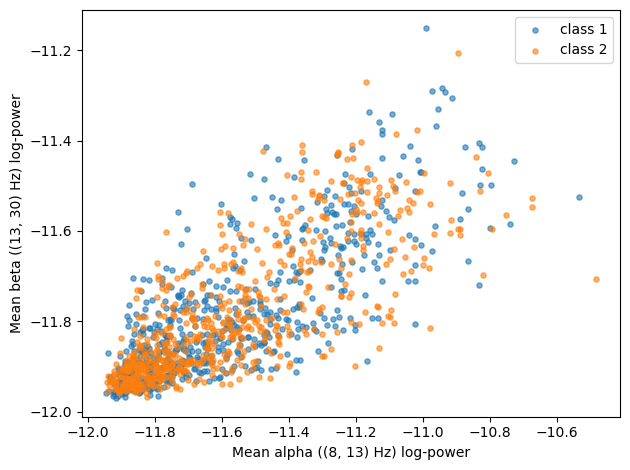

In [ ]:
from feature_extraction import BANDS

n_ch = X.shape[1] // 2                # first half = alpha(μ), second half = beta
alpha_mean = X[:, :n_ch].mean(axis=1) # mean over channels
beta_mean  = X[:, n_ch:].mean(axis=1)

plt.figure()
for cls in np.unique(y):
    m = (y == cls)
    plt.scatter(alpha_mean[m], beta_mean[m], s=14, alpha=0.6, label=f"class {cls}")
plt.xlabel(f"Mean {list(BANDS.keys())[0]} ({list(BANDS.values())[0]} Hz) log-power")
plt.ylabel(f"Mean {list(BANDS.keys())[1]} ({list(BANDS.values())[1]} Hz) log-power")
plt.legend(); plt.tight_layout()


### Un-supervised dimensionality reduction

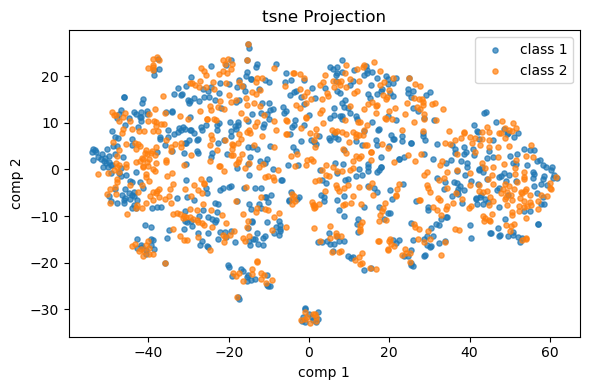

In [ ]:
from src.feature_extraction import reduce_features

method = "tsne"
Z, mdl, info = reduce_features(X, method=method, n_components=2)
# print("PCA explained variance:", np.round(info.get("expl_var", []), 3))

# Scatter by class
plt.figure(figsize=(6,4))
for cls in np.unique(y):
    m = (y == cls)
    plt.scatter(Z[m,0], Z[m,1], s=14, alpha=0.7, label=f"class {cls}")
plt.xlabel("comp 1"); plt.ylabel("comp 2"); plt.title(f"{method} Projection"); plt.legend(); plt.tight_layout()
plt.show()



### Supervised dimensionality reduction (LDA)

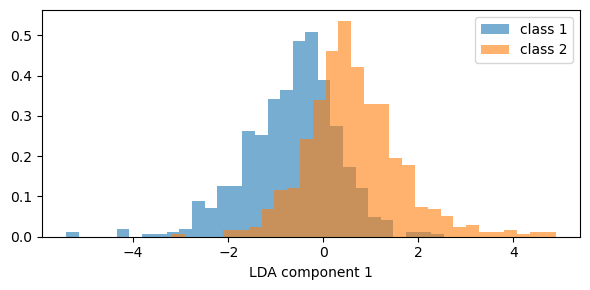

In [128]:
Z, mdl, info = reduce_features(X, y=y, method="lda", n_components=1) # supervised

plt.figure(figsize=(6,3))
for cls in np.unique(y):
    m = (y == cls)
    plt.hist(Z[m, 0], bins=30, alpha=0.6, label=f"class {cls}", density=True)
plt.xlabel("LDA component 1"); plt.legend(); plt.tight_layout()
